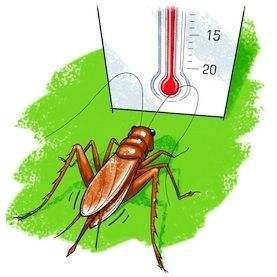

In [1]:
from IPython.display import Image
Image("../images/cricket.jpg")

# Introduction Data Science
# Assignment 1: Linear Regression from scratch

### In this assignment you will implement linear regression without the use of any machine learning package

### Learning goals:
- Understand how to build a simple estimator class
- Understand how to implement gradient descent
- Learn to play with hyperparameters

# Import packages

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [3]:
cricket_df = pd.read_csv('../data/crickets_weather.csv', sep=';')
print('Shape of df: {}'.format(cricket_df.shape))
cricket_df

Shape of df: (15, 3)


,Temperature (F),Cricket Chirps (chirps/sec),Avg Chirp Volume
0,88.6,20.0,101.46
1,71.6,16.0,69.00
2,93.3,19.8,89.07
3,84.3,18.4,103.80
4,80.6,17.1,94.32
5,75.2,15.5,46.83
6,69.7,14.7,73.35
7,82.0,17.1,64.02
8,69.4,15.4,59.64
9,83.3,16.2,69.75


**The data consits of only 15 rows and three columns.**

**The goal is to predict the temperature with the speed of cricket chirps and the volume of the chirps in a certain forest.**

# Explore data
Check whether a relationship is identfiable between the features and the temperature

In [4]:
# check for missing values or outliers and get an initial feeling for the data.
cricket_df.describe()

,Temperature (F),Cricket Chirps (chirps/sec),Avg Chirp Volume
count,15.000000,15.000000,15.00000
mean,80.040000,16.653333,75.26200
std,6.707331,1.702044,16.50831
min,69.400000,14.400000,46.83000
25%,75.750000,15.450000,64.44000
50%,80.600000,16.200000,69.75000
75%,83.400000,17.150000,88.74000
max,93.300000,20.000000,103.80000


In [5]:
# Check correlation between all variables
cricket_df.corr()

,Temperature (F),Cricket Chirps (chirps/sec),Avg Chirp Volume
Temperature (F),1.000000,0.835144,0.598763
Cricket Chirps (chirps/sec),0.835144,1.000000,0.756068
Avg Chirp Volume,0.598763,0.756068,1.000000


### Set the dependent variable (y)  and feature variables (X)

In [6]:
# Get the values of y and X as an array.
y = cricket_df['Temperature (F)'].values
X = cricket_df[['Cricket Chirps (chirps/sec)', 'Avg Chirp Volume']].values

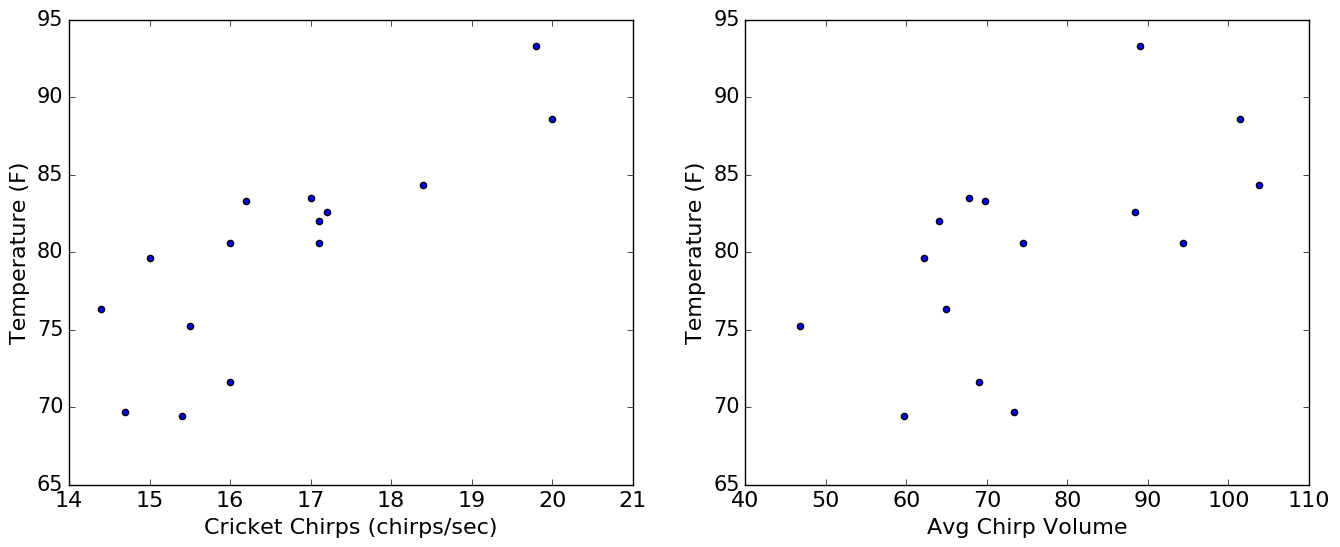

In [7]:
# visualize data
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.scatter(X[:,0], y)
plt.xlabel('Cricket Chirps (chirps/sec)', size=16)
plt.ylabel('Temperature (F)', size=16)
plt.xticks(size=16);
plt.yticks(size=15);

plt.subplot(1,2,2)
plt.scatter(X[:,1], y);
plt.xlabel('Avg Chirp Volume', size=16);
plt.ylabel('Temperature (F)', size=16);
plt.xticks(size=16);
plt.yticks(size=15);

plt.show()

# Implementing linear regression from scratch
Now we have checked that the data is clean and there are obvious linear relationships in the data, it makes sense to use a linear regression to estimate $y$.

The implementation consists of three steps:
   1. Initialize the class
   2. Develop a function that can make predicitons with a given model (coefficients or weights)
   3. Fit a model using gradient descent in order to return the model with the lowest mean squared error

## Step 1 and 2
### 1. Initialize the class
### 2. Develop function that can make predictions

In [8]:
class LinearRegression(object):
    """
    Least squares linear regression
    
    Parameters
    ----------
    n_iter: positive integer
        number of iterations to perform gradient descent
        
    eta: float [0,1]
        learning rate
    """
    
    def __init__(self, n_iter=200, eta=0.00001):
        self.eta = eta
        self.n_iter = n_iter
        

    def predict(self, X):
        """
        Predict using the linear model
        
        Parameters
        ----------
        X: array, shape = (n_samples, n_features)
        
        return: array with predictions
        """
        # set an intercept term and add to X
        intercept = np.ones((X.shape[0], 1))
        X = np.append(intercept, X, axis=1)
        # set weights for testing as one for all weights (including the intercept term)
        self.weights = np.ones(X.shape[1])
        # calculate estimated y per observation (dot product of X and y)
        return np.dot(X, self.weights)

### Test predict function
Note: possibly, the implementation of the predict function requires that X has the shape (n_samples, n_features). When selecting only one column of X, Python will automatically change its shape to (n_sample,). The numpy reshape manipulation below gives the array the shape (n_samples, 1).

In [9]:
lr_test_predict = LinearRegression()

In [10]:
# get predictions using only the first feature
print(lr_test_predict.predict(X[:,0].reshape(-1,1)))

[ 21.   17.   20.8  19.4  18.1  16.5  15.7  18.1  16.4  17.2  16.   18.2
  17.   18.   15.4]


In [11]:
# get predictions using only the second feature
print(lr_test_predict.predict(X[:,1].reshape(-1,1)))

[ 102.46   70.     90.07  104.8    95.32   47.83   74.35   65.02   60.64
   70.75   63.16   89.41   75.43   68.83   65.86]


In [12]:
# get predictions using both features
print(lr_test_predict.predict(X))

[ 122.46   86.    109.87  123.2   112.42   63.33   89.05   82.12   76.04
   86.95   78.16  106.61   91.43   85.83   80.26]


## 3. Estimate weights using gradient descent

**Stochastic gradient descent requires two parameters:**

**Learning Rate (eta)**:
Used to limit the amount each coefficient is corrected each time it is updated.

**Iterations (n_iter)**: The number of times to run through the training data while updating the coefficients.
These, along with the training data will be the arguments to the function.


**There are 5 steps we need to perform in the fit function:**

1. Loop over each iteration
2. Predict the values with weights of current iteration
3. Calculate the cost (Mean Squared Error) with these predictions
4. Calculate the gradient.
5. Update the weights

In [13]:
class LinearRegressionGD(object):
    """
    Least squares linear regression
    
    Parameters
    ----------
    n_iter: positive integer
        number of iterations to perform gradient descent
        
    eta: float [0,1]
        learning rate
    
    print_iter: boolean
        when true, show cost during traing after each 20 iterations
    """
    
    def __init__(self, n_iter=200, eta=0.0001, print_iter=False):
        self.eta = eta
        self.n_iter = n_iter
        self.print_iter = print_iter
            
    def predict(self, X):
        # Add intercept, only in the case it is not yet added
        if X.shape[1] == len(self.weights) - 1:
            intercept = np.ones((X.shape[0], 1))
            X = np.append(intercept, X, axis=1)
        return np.dot(X, self.weights)
    
    def fit(self, X, y):
        """
        Fit linear model
        
        Parameters
        ----------
        X: array, shape = (n_samples, n_features)
        y: array, shape = (n_samples, )
        
        returns: self  
        """
        # keep track of costs
        self.costs = []
        
        # initialize weights
        self.weights = np.zeros(1+X.shape[1])

        # add intercept
        intercept = np.ones((X.shape[0], 1))
        X = np.append(intercept, X, axis=1)
        
        # loop over each iteration
        for i in range(self.n_iter):
            # predict values with weights of current iterations
            y_hat = self.predict(X)
            # calculate cost (mean squared error)
            error = y_hat - y
            n_obs = len(y)
            cost = np.sum(error ** 2) / n_obs
            # keep track of cost per iteration
            self.costs.append(cost)
            
            # print cost per 20 iterations to check if MSE is converging
            if self.print_iter:
                if (i+1) % 20 == 0:
                    print("Iteration {} | Cost: {:.2f}".format(i+1, cost))
     
            # calculate the gradient
            gradient = np.dot(X.transpose(), error) / n_obs
            
            # update weights
            self.weights -= self.eta * gradient
        return self

## Test fit function

In [14]:
lr = LinearRegressionGD(eta=0.0001, n_iter=200, print_iter=True)
lr.fit(X[:,0].reshape(-1,1),y)
y_hat = lr.predict(X[:,0].reshape(-1,1))

y_hat

Iteration 20 | Cost: 2195.23
Iteration 40 | Cost: 714.66
Iteration 60 | Cost: 241.24
Iteration 80 | Cost: 89.87
Iteration 100 | Cost: 41.46
Iteration 120 | Cost: 25.99
Iteration 140 | Cost: 21.04
Iteration 160 | Cost: 19.45
Iteration 180 | Cost: 18.95
Iteration 200 | Cost: 18.79


array([ 95.45851496,  76.42437371,  94.5068079 ,  87.84485846,
        81.65876256,  74.04510606,  70.23827781,  81.65876256,
        73.56925252,  77.37608077,  71.6658384 ,  82.13461609,
        76.42437371,  81.18290902,  68.81071721])

## Questions:
- **Which feature is better in predicting the temperature?**
- **Are the predictions more accurate when you use both features?**

## Plot results

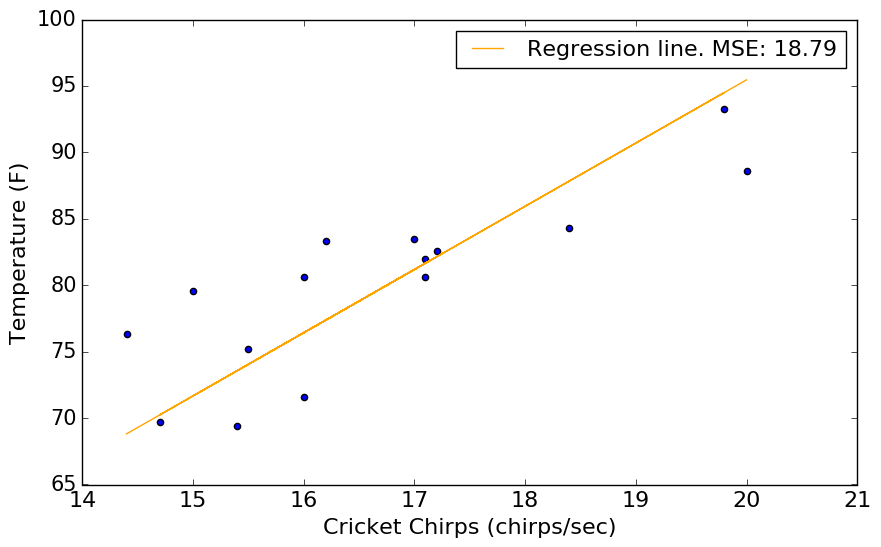

In [15]:
def plot_regression_line(lr, X, y):
    lr.print_iter = False
    lr.fit(X, y)
    y_hat = lr.predict(X)
    
    plt.figure(figsize=(10,6));
    plt.scatter(X, y);
    plt.plot(X, y_hat, '-', c='orange', label='Regression line. MSE: {:.2f}'.format(lr.costs[-1]));
    plt.xlabel('Cricket Chirps (chirps/sec)', size=16);
    plt.ylabel('Temperature (F)', size=16);
    plt.xticks(size=16);
    plt.yticks(size=15);
    plt.legend(fontsize=16);
    
plot_regression_line(lr, X[:,0].reshape(-1,1), y)

# Choosing learning rate hyperparameter
Making a plot can help in setting a good hyperparamter. Use the plotting function below to choose an appropriate learning rate.


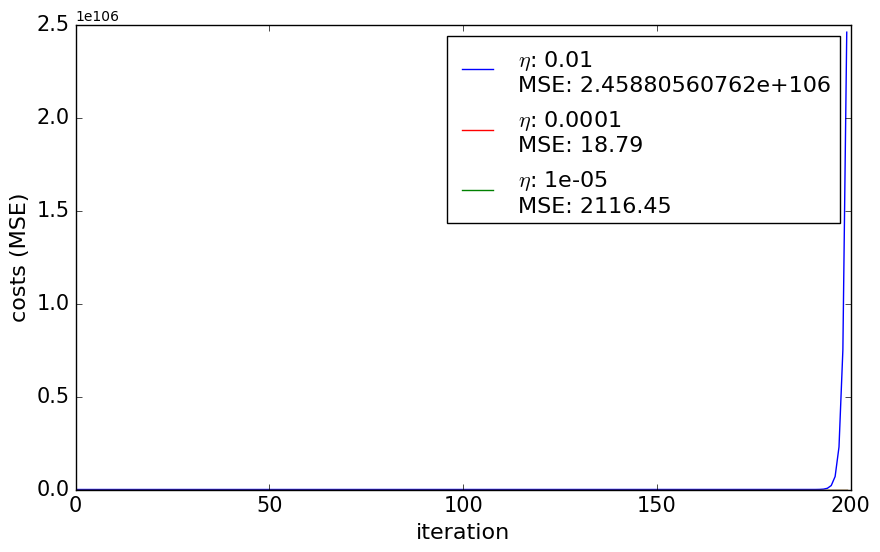

In [17]:
def plot_learning_rate(X, n_iter, eta_list):
    colors = ['blue', 'red', 'green', 'brown', 'yellow']
    plt.figure(figsize=(10,6))
    for eta, c in zip(eta_list, colors):
        lr = LinearRegressionGD(n_iter, eta)
        lr.fit(X, y)
        plt.plot(lr.costs, color=c, label='$\eta$: {}\nMSE: {:}'.format(eta, round(lr.costs[-1],2)))
    plt.legend(fontsize=16)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel('iteration', size=16)
    plt.ylabel('costs (MSE)', size=16)

eta_list = [0.01, 0.0001, 0.00001]
plot_learning_rate(X=X[:,0].reshape(-1,1), n_iter=200, eta_list=eta_list)